In [1]:
!pip install torchvision==0.12.0 numpy==1.19.2 albumentations==0.4.3 diffusers opencv-python==4.1.2.30 pudb==2019.2 invisible-watermark imageio==2.9.0 imageio-ffmpeg==0.4.2 pytorch-lightning==1.4.2 omegaconf==2.1.1
!pip install test-tube>=0.7.5 streamlit>=0.73.1 einops==0.3.0 torch-fidelity==0.3.0 torchmetrics==0.6.0 kornia==0.6

!pip install ftfy ipywidgets matplotlib pyrallis torch==1.12.0 diffusers==0.12.1 transformers==4.26.0 accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 51.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (pyproject.toml) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
  Using cached torch-1.12.0-cp310-cp310-manylinux1_x86_64.whl (776.3 MB)
  Attempting uninstall: torch
    Found existing installation: torch 2.1.0
    Uninstalling torch-2.1.0:
      Successfully uninstalled torch-2.1.0
ERROR: pip's dependency resol

In [2]:
%cd Attend-and-Excite-personal

fatal: destination path 'Attend-and-Excite-personal' already exists and is not an empty directory.
/content/Attend-and-Excite-personal


In [3]:
from typing import List, Dict, Optional
import torch

import sys
sys.path.append(".")
sys.path.append("..")

from pipeline_attend_and_excite import AttendAndExcitePipeline
from config import RunConfig
from run import run_on_prompt, get_indices_to_alter, read_associated_indices
from utils import vis_utils
from utils.ptp_utils import AttentionStore

%load_ext autoreload
%autoreload 2

# Load Model Weights (may take a few minutes)

In [4]:
import torch
NUM_DIFFUSION_STEPS = 50
GUIDANCE_SCALE = 7.5
MAX_NUM_WORDS = 77
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
stable = AttendAndExcitePipeline.from_pretrained("CompVis/stable-diffusion-v1-4").to(device)
stable = stable.to(torch.float16)# EDIT
tokenizer = stable.tokenizer

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

safety_checker/pytorch_model.fp16.safetensors not found


Fetching 21 files:   0%|          | 0/21 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

(…)kpoints/scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/492M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

pytorch_model.fp16.bin:   0%|          | 0.00/608M [00:00<?, ?B/s]

pytorch_model.fp16.bin:   0%|          | 0.00/246M [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.bin:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

diffusion_pytorch_model.non_ema.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


# Pipeline Wrapper

In [17]:
# configurable parameters (see RunConfig for all parameters)
# scale factor - intensity of shift by gradient
# thresholds - a dictionary for iterative refinement mapping the iteration number to the attention threshold
# max_iter_to_alter- maximal inference timestep to apply Attend-and-Excite
def run_and_display(prompts: List[str],
                    controller: AttentionStore,
                    indices_to_alter: List[int],
                    groups: List[List[int]],
                    generator: torch.Generator,
                    run_standard_sd: bool = False,
                    scale_factor: int = 20,
                    thresholds: Dict[int, float] = {0:0.05, 10: 0.5, 20: 0.8},
                    max_iter_to_alter: int = 50,
                    display_output: bool = False,
                    sd_2_1: bool = False):
    config = RunConfig(prompt=prompts[0],
                       run_standard_sd=run_standard_sd,
                       scale_factor=scale_factor,
                       thresholds=thresholds,
                       max_iter_to_alter=max_iter_to_alter,
                       sd_2_1=sd_2_1)
    image = run_on_prompt(model=stable,
                          prompt=prompts,
                          controller=controller,
                          token_indices=indices_to_alter,
                          seed=generator,
                          config=config)
    if display_output:
        display(image)
    return image

# Run Inference on a Set of Seeds and Generate an Image Grid

In [18]:
def generate_images_for_method(prompt: str,
                               seeds: List[int],
                               indices_to_alter: Optional[List[int]] = None,
                               groups: Optional[List[List[int]]]=None,
                               is_attend_and_excite: bool = True,
                               sd_2_1: bool = False):
    token_indices = get_indices_to_alter(stable, prompt) if indices_to_alter is None else indices_to_alter
    images = []
    for seed in seeds:
        g = torch.Generator('cuda').manual_seed(seed)
        prompts = [prompt]
        controller = AttentionStore()
        run_standard_sd = False if is_attend_and_excite else True
        image = run_and_display(prompts=prompts,
                                controller=controller,
                                indices_to_alter=token_indices,
                                groups=groups,
                                generator=g,
                                run_standard_sd=run_standard_sd,
                                sd_2_1=sd_2_1)
        images.append(image.resize((256, 256)))
    grid = vis_utils.get_image_grid(images)
    display(grid)

In [14]:
all_prompts, all_groups, all_indices_to_alter = read_associated_indices(path='multi_obj_prompts_with_association.csv', group_split_char='|',shift_idxs=1)

In [8]:
all_prompts[11]

"A brown teddy bear, a yellow rubber duck, a blue ball, and a green toy car on a children's play mat."

# Stable Diffusion vs. Attend-and-Excite

## Stable Diffusion

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

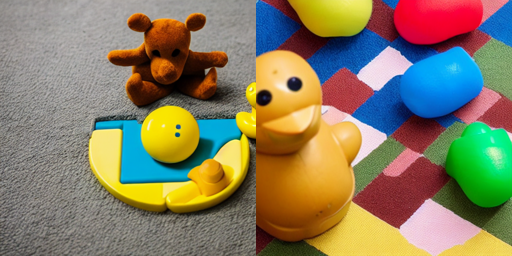

In [9]:
# generate_images_for_method(
#     prompt="a cat and a frog",
#     seeds=[6141, 9031, 969, 1910],
#     groups=None,
#     is_attend_and_excite=False
# )
'''
VANILLA STABLE DIFFUSION
'''
generate_images_for_method(
    prompt=all_prompts[11],
    indices_to_alter=all_indices_to_alter[11],
    groups=None, # REGULAR attend and excite
    seeds=[6141, 9031],
    is_attend_and_excite=False
)


  0%|          | 0/50 [00:00<?, ?it/s]

	 Try 1. rubber has a max attention of 0.005886077880859375
	 Try 2. 's has a max attention of 0.0059661865234375
	 Try 3. rubber has a max attention of 0.00646209716796875
	 Try 4. 's has a max attention of 0.00652313232421875
	 Try 5. rubber has a max attention of 0.007022857666015625
	 Try 6. 's has a max attention of 0.00705718994140625
	 Try 7. rubber has a max attention of 0.007549285888671875
	 Try 8. 's has a max attention of 0.007556915283203125
	 Try 9. rubber has a max attention of 0.00803375244140625
	 Try 10. 's has a max attention of 0.00799560546875
	 Try 11. rubber has a max attention of 0.00846099853515625
	 Try 12. 's has a max attention of 0.00838470458984375
	 Try 13. rubber has a max attention of 0.00884246826171875
	 Try 14. rubber has a max attention of 0.0090179443359375
	 Try 15. 's has a max attention of 0.00888824462890625
	 Try 16. 's has a max attention of 0.00902557373046875
	 Try 17. rubber has a max attention of 0.00946044921875
	 Try 18. 's has a max at

  0%|          | 0/50 [00:00<?, ?it/s]

	 Try 1. rubber has a max attention of 0.0031185150146484375
	 Try 2. rubber has a max attention of 0.0032367706298828125
	 Try 3. rubber has a max attention of 0.00335693359375
	 Try 4. rubber has a max attention of 0.00347137451171875
	 Try 5. rubber has a max attention of 0.0035839080810546875
	 Try 6. 's has a max attention of 0.003627777099609375
	 Try 7. rubber has a max attention of 0.00380706787109375
	 Try 8. rubber has a max attention of 0.00391387939453125
	 Try 9. rubber has a max attention of 0.00400543212890625
	 Try 10. rubber has a max attention of 0.0041046142578125
	 Try 11. 's has a max attention of 0.0041351318359375
	 Try 12. rubber has a max attention of 0.004283905029296875
	 Try 13. rubber has a max attention of 0.00437164306640625
	 Try 14. rubber has a max attention of 0.004451751708984375
	 Try 15. rubber has a max attention of 0.004528045654296875
	 Try 16. rubber has a max attention of 0.00460052490234375
	 Try 17. 's has a max attention of 0.00463104248046

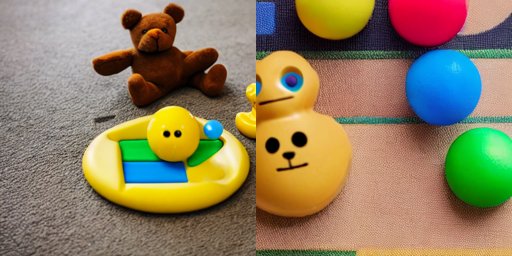

In [10]:
'''
REGULAR ATTEND AND EXCITE
'''
generate_images_for_method(
    prompt=all_prompts[11],
    indices_to_alter=all_indices_to_alter[11],
    groups=None, # REGULAR attend and excite
    seeds=[6141, 9031],
    is_attend_and_excite=True
)

## Attend-and-Excite

  0%|          | 0/50 [00:00<?, ?it/s]

	 Try 1. rubber has a max attention of 0.005886077880859375
	 Try 2. rubber has a max attention of 0.006175994873046875
	 Try 3. rubber has a max attention of 0.0064697265625
	 Try 4. rubber has a max attention of 0.00676727294921875
	 Try 5. rubber has a max attention of 0.00704193115234375
	 Try 6. rubber has a max attention of 0.007320404052734375
	 Try 7. rubber has a max attention of 0.0075836181640625
	 Try 8. rubber has a max attention of 0.007843017578125
	 Try 9. rubber has a max attention of 0.00807952880859375
	 Try 10. rubber has a max attention of 0.00830078125
	 Try 11. rubber has a max attention of 0.008514404296875
	 Try 12. rubber has a max attention of 0.0087127685546875
	 Try 13. rubber has a max attention of 0.0088958740234375
	 Try 14. rubber has a max attention of 0.00907135009765625
	 Try 15. rubber has a max attention of 0.0092315673828125
	 Try 16. rubber has a max attention of 0.0093841552734375
	 Try 17. rubber has a max attention of 0.009521484375
	 Try 18. 

  0%|          | 0/50 [00:00<?, ?it/s]

	 Try 1. rubber has a max attention of 0.0031185150146484375
	 Try 2. rubber has a max attention of 0.0032367706298828125
	 Try 3. rubber has a max attention of 0.00335693359375
	 Try 4. rubber has a max attention of 0.00347137451171875
	 Try 5. rubber has a max attention of 0.0035839080810546875
	 Try 6. rubber has a max attention of 0.003692626953125
	 Try 7. rubber has a max attention of 0.003803253173828125
	 Try 8. rubber has a max attention of 0.003910064697265625
	 Try 9. rubber has a max attention of 0.00400543212890625
	 Try 10. rubber has a max attention of 0.004100799560546875
	 Try 11. rubber has a max attention of 0.004184722900390625
	 Try 12. rubber has a max attention of 0.00428009033203125
	 Try 13. rubber has a max attention of 0.004364013671875
	 Try 14. rubber has a max attention of 0.00444793701171875
	 Try 15. rubber has a max attention of 0.004520416259765625
	 Try 16. rubber has a max attention of 0.0045928955078125
	 Try 17. rubber has a max attention of 0.0046

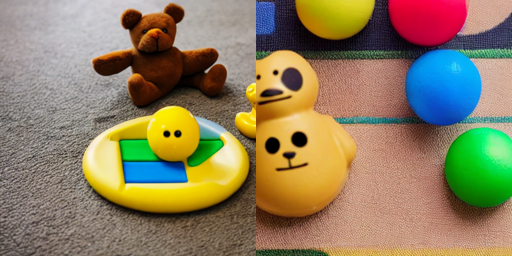

In [19]:
# generate_images_for_method(
#     prompt="a cat and a frog",
#     seeds=[6141, 9031, 969, 1910],
#     is_attend_and_excite=True
# )
generate_images_for_method(
    prompt=all_prompts[11],
    indices_to_alter=all_indices_to_alter[11],
    groups=all_groups[11], # OUR VERSION
    seeds=[6141, 9031],
    is_attend_and_excite=True
)

In [15]:
'''
So far results of new loss are not too different from original AE
Things to tune?
  -num iters
  -threshold for iterative refine?
  -step size? (is there this?)
  -Revisit loss functions entirely
'''

print(all_prompts[11])
print(all_indices_to_alter[11])
print(all_groups[11])

A brown teddy bear, a yellow rubber duck, a blue ball, and a green toy car on a children's play mat.
[2, 3, 4, 7, 8, 9, 12, 13, 17, 18, 19, 22, 24, 25]
[[2, 3, 4], [7, 8, 9], [12, 13], [17, 18, 19], [22, 24, 25]]


## Stable Diffusion

In [ ]:
generate_images_for_method(
    prompt="a mouse, a ball, and a red car.",
    seeds=[7803, 2098, 15792, 2354],
    is_attend_and_excite=False
)

## Attend-and-Excite

{1: 'a', 2: 'mouse', 3: 'and', 4: 'a', 5: 'red', 6: 'car'}
Please enter the a comma-separated list indices of the tokens you wish to alter (e.g., 2,5): 2,6
Altering tokens: ['mouse', 'car']


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0 | Loss: 0.8952
Iteration 1 | Loss: 0.0166
Iteration 2 | Loss: 0.0149
Iteration 3 | Loss: 0.0004
Iteration 4 | Loss: 0.0002
Iteration 5 | Loss: 0.0001
Iteration 6 | Loss: 0.0003
Iteration 7 | Loss: 0.0004
Iteration 8 | Loss: 0.0011
Iteration 9 | Loss: 0.0032
Iteration 10 | Loss: 0.0042
Iteration 11 | Loss: 0.0156
Iteration 12 | Loss: 0.0145
Iteration 13 | Loss: 0.0366
Iteration 14 | Loss: 0.0349
Iteration 15 | Loss: 0.0452
Iteration 16 | Loss: 0.0412
Iteration 17 | Loss: 0.0397
Iteration 18 | Loss: 0.0353
Iteration 19 | Loss: 0.0355
Iteration 20 | Loss: 0.0384
Iteration 21 | Loss: 0.0429
Iteration 22 | Loss: 0.0424
Iteration 23 | Loss: 0.0449
Iteration 24 | Loss: 0.0461


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0 | Loss: 0.8401
Iteration 1 | Loss: 0.0049
Iteration 2 | Loss: 0.0042
Iteration 3 | Loss: 0.0037
Iteration 4 | Loss: 0.0032
Iteration 5 | Loss: 0.0018
Iteration 6 | Loss: 0.0036
Iteration 7 | Loss: 0.0046
Iteration 8 | Loss: 0.0069
Iteration 9 | Loss: 0.0098
Iteration 10 | Loss: 0.0102
Iteration 11 | Loss: 0.0142
Iteration 12 | Loss: 0.0134
Iteration 13 | Loss: 0.0147
Iteration 14 | Loss: 0.0163
Iteration 15 | Loss: 0.0155
Iteration 16 | Loss: 0.0201
Iteration 17 | Loss: 0.0196
Iteration 18 | Loss: 0.0244
Iteration 19 | Loss: 0.0247
Iteration 20 | Loss: 0.0283
Iteration 21 | Loss: 0.0293
Iteration 22 | Loss: 0.0331
Iteration 23 | Loss: 0.0352
Iteration 24 | Loss: 0.0390


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0 | Loss: 0.8940
Iteration 1 | Loss: 0.6057
Iteration 2 | Loss: 0.5241
Iteration 3 | Loss: 0.1050
Iteration 4 | Loss: 0.0053
Iteration 5 | Loss: 0.0215
Iteration 6 | Loss: 0.0154
Iteration 7 | Loss: 0.0197
Iteration 8 | Loss: 0.0252
Iteration 9 | Loss: 0.0283
Iteration 10 | Loss: 0.0445
Iteration 11 | Loss: 0.0352
Iteration 12 | Loss: 0.0587
Iteration 13 | Loss: 0.0394
Iteration 14 | Loss: 0.0614
Iteration 15 | Loss: 0.0392
Iteration 16 | Loss: 0.0485
Iteration 17 | Loss: 0.0418
Iteration 18 | Loss: 0.0428
Iteration 19 | Loss: 0.0392
Iteration 20 | Loss: 0.0406
Iteration 21 | Loss: 0.0379
Iteration 22 | Loss: 0.0406
Iteration 23 | Loss: 0.0371
Iteration 24 | Loss: 0.0419


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0 | Loss: 0.7272
Iteration 1 | Loss: 0.0227
Iteration 2 | Loss: 0.0199
Iteration 3 | Loss: 0.0058
Iteration 4 | Loss: 0.0109
Iteration 5 | Loss: 0.0154
Iteration 6 | Loss: 0.0231
Iteration 7 | Loss: 0.0210
Iteration 8 | Loss: 0.0348
Iteration 9 | Loss: 0.0232
Iteration 10 | Loss: 0.0410
Iteration 11 | Loss: 0.0319
Iteration 12 | Loss: 0.0405
Iteration 13 | Loss: 0.0650
Iteration 14 | Loss: 0.0573
Iteration 15 | Loss: 0.0783
Iteration 16 | Loss: 0.0598
Iteration 17 | Loss: 0.0642
Iteration 18 | Loss: 0.0451
Iteration 19 | Loss: 0.0556
Iteration 20 | Loss: 0.0369
Iteration 21 | Loss: 0.0498
Iteration 22 | Loss: 0.0317
Iteration 23 | Loss: 0.0451
Iteration 24 | Loss: 0.0308


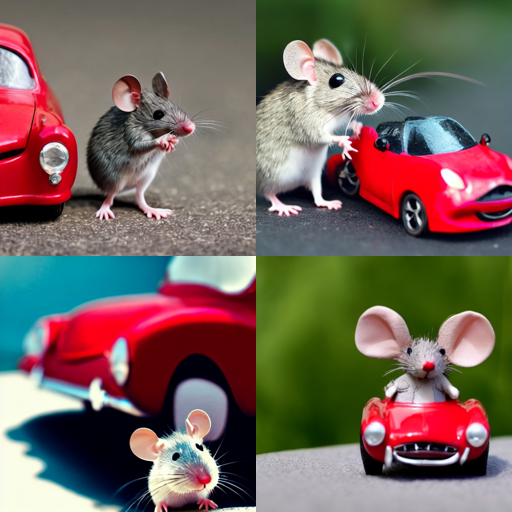

In [ ]:
generate_images_for_method(
    prompt="a mouse and a red car",
    seeds=[7803, 2098, 15792, 2354],
    is_attend_and_excite=True
)

# Stable Diffusion 2.1

In [ ]:
NUM_DIFFUSION_STEPS = 50
GUIDANCE_SCALE = 7.5
MAX_NUM_WORDS = 77
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
stable = AttendAndExcitePipeline.from_pretrained("stabilityai/stable-diffusion-2-1-base").to(device)
tokenizer = stable.tokenizer

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

{1: 'a', 2: 'cat', 3: 'and', 4: 'a', 5: 'dog'}
Please enter the a comma-separated list indices of the tokens you wish to alter (e.g., 2,5): 2,5
Altering tokens: ['cat', 'dog']


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

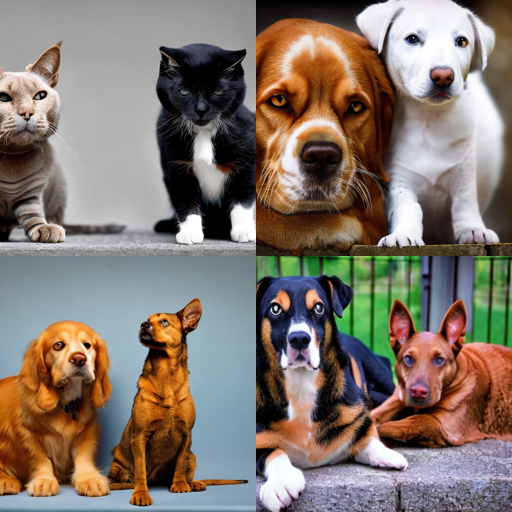

In [ ]:
generate_images_for_method(
    prompt="a cat and a dog",
    seeds=[39, 63, 68, 62],
    is_attend_and_excite=False,
    sd_2_1=True
)

{1: 'a', 2: 'cat', 3: 'and', 4: 'a', 5: 'dog'}
Please enter the a comma-separated list indices of the tokens you wish to alter (e.g., 2,5): 2,5
Altering tokens: ['cat', 'dog']


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0 | Loss: 0.3958
Iteration 1 | Loss: 0.3280
Iteration 2 | Loss: 0.3427
Iteration 3 | Loss: 0.1661
Iteration 4 | Loss: 0.1190
Iteration 5 | Loss: 0.0945
Iteration 6 | Loss: 0.0955
Iteration 7 | Loss: 0.0894
Iteration 8 | Loss: 0.0798
Iteration 9 | Loss: 0.0650
Iteration 10 | Loss: 0.0674
Iteration 11 | Loss: 0.0554
Iteration 12 | Loss: 0.0626
Iteration 13 | Loss: 0.0520
Iteration 14 | Loss: 0.0562
Iteration 15 | Loss: 0.0540
Iteration 16 | Loss: 0.0580
Iteration 17 | Loss: 0.0555
Iteration 18 | Loss: 0.0591
Iteration 19 | Loss: 0.0577
Iteration 20 | Loss: 0.0603
Iteration 21 | Loss: 0.0610
Iteration 22 | Loss: 0.0623
Iteration 23 | Loss: 0.0640
Iteration 24 | Loss: 0.0669


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0 | Loss: 0.4346
Iteration 1 | Loss: 0.4535
Iteration 2 | Loss: 0.4684
Iteration 3 | Loss: 0.3153
Iteration 4 | Loss: 0.1984
Iteration 5 | Loss: 0.1573
Iteration 6 | Loss: 0.1456
Iteration 7 | Loss: 0.1201
Iteration 8 | Loss: 0.1350
Iteration 9 | Loss: 0.1008
Iteration 10 | Loss: 0.1329
Iteration 11 | Loss: 0.0906
Iteration 12 | Loss: 0.1296
Iteration 13 | Loss: 0.0818
Iteration 14 | Loss: 0.1011
Iteration 15 | Loss: 0.0720
Iteration 16 | Loss: 0.0843
Iteration 17 | Loss: 0.0660
Iteration 18 | Loss: 0.0814
Iteration 19 | Loss: 0.0623
Iteration 20 | Loss: 0.0844
Iteration 21 | Loss: 0.0625
Iteration 22 | Loss: 0.0759
Iteration 23 | Loss: 0.0679
Iteration 24 | Loss: 0.0725


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0 | Loss: 0.4947
Iteration 1 | Loss: 0.5245
Iteration 2 | Loss: 0.5280
Iteration 3 | Loss: 0.2731
Iteration 4 | Loss: 0.1977
Iteration 5 | Loss: 0.1962
Iteration 6 | Loss: 0.1827
Iteration 7 | Loss: 0.1865
Iteration 8 | Loss: 0.1470
Iteration 9 | Loss: 0.1522
Iteration 10 | Loss: 0.1503
Iteration 11 | Loss: 0.1438
Iteration 12 | Loss: 0.1330
Iteration 13 | Loss: 0.1239
Iteration 14 | Loss: 0.1183
Iteration 15 | Loss: 0.1111
Iteration 16 | Loss: 0.1059
Iteration 17 | Loss: 0.1010
Iteration 18 | Loss: 0.0981
Iteration 19 | Loss: 0.0967
Iteration 20 | Loss: 0.0967
Iteration 21 | Loss: 0.0975
Iteration 22 | Loss: 0.0990
Iteration 23 | Loss: 0.1005
Iteration 24 | Loss: 0.1025


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0 | Loss: 0.3568
Iteration 1 | Loss: 0.3141
Iteration 2 | Loss: 0.3440
Iteration 3 | Loss: 0.1994
Iteration 4 | Loss: 0.1034
Iteration 5 | Loss: 0.0802
Iteration 6 | Loss: 0.0877
Iteration 7 | Loss: 0.0764
Iteration 8 | Loss: 0.0889
Iteration 9 | Loss: 0.0600
Iteration 10 | Loss: 0.0542
Iteration 11 | Loss: 0.0406
Iteration 12 | Loss: 0.0441
Iteration 13 | Loss: 0.0340
Iteration 14 | Loss: 0.0366
Iteration 15 | Loss: 0.0274
Iteration 16 | Loss: 0.0309
Iteration 17 | Loss: 0.0273
Iteration 18 | Loss: 0.0306
Iteration 19 | Loss: 0.0290
Iteration 20 | Loss: 0.0332
Iteration 21 | Loss: 0.0325
Iteration 22 | Loss: 0.0365
Iteration 23 | Loss: 0.0381
Iteration 24 | Loss: 0.0385


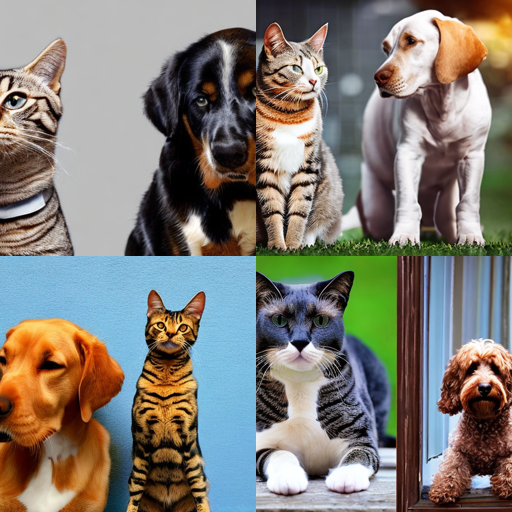

In [ ]:
generate_images_for_method(
    prompt="a cat and a dog",
    seeds=[39, 63, 68, 62],
    is_attend_and_excite=True,
    sd_2_1=True
)